###LSTM Model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model

# Load data from the CSV file
data = pd.read_csv("data.csv")

# Convert the 'red' and 'blue' columns to NumPy arrays
X_red = np.array(data["red"])
X_blue = np.array(data["blue"])

# Convert the 'outcome' column to two NumPy arrays, Y_red and Y_blue
Y_red, Y_blue = np.array(data["outcome"]).T

# Convert the target labels to one-hot encoded arrays and convert outcomes to integers
num_classes = 6
Y_red = np.array(Y_red, dtype=np.int32)
Y_blue = np.array(Y_blue, dtype=np.int32)
Y_red = np.eye(num_classes)[Y_red - 1]  # one-hot encode
Y_blue = np.eye(num_classes)[Y_blue - 1]

# Model Architecture
seq_length = 5

# Create the combined model for red and blue dice
input_red = Input(shape=(seq_length, 1))
input_blue = Input(shape=(seq_length, 1))

# Shared LSTM layers
shared_lstm1 = LSTM(128, return_sequences=True)
shared_lstm2 = LSTM(64)

# Red dice branch
x_red = shared_lstm1(input_red)
x_red = Dropout(0.2)(x_red)
x_red = BatchNormalization()(x_red)
x_red = shared_lstm2(x_red)

# Blue dice branch
x_blue = shared_lstm1(input_blue)
x_blue = Dropout(0.2)(x_blue)
x_blue = BatchNormalization()(x_blue)
x_blue = shared_lstm2(x_blue)

# Merge both branches and add additional Dense layers
merged = concatenate([x_red, x_blue])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Output layers for red and blue dice
output_red = Dense(num_classes, activation='softmax', name='red_outcome')(x)
output_blue = Dense(num_classes, activation='softmax', name='blue_outcome')(x)

# Create the combined model
model = Model(inputs=[input_red, input_blue], outputs=[output_red, output_blue])

# Compile the model with custom loss function
def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy])

# Train the model
model.fit([X_red.reshape(-1, seq_length, 1), X_blue.reshape(-1, seq_length, 1)],
          [Y_red, Y_blue],
          epochs=150,
          batch_size=32,
          verbose=1)

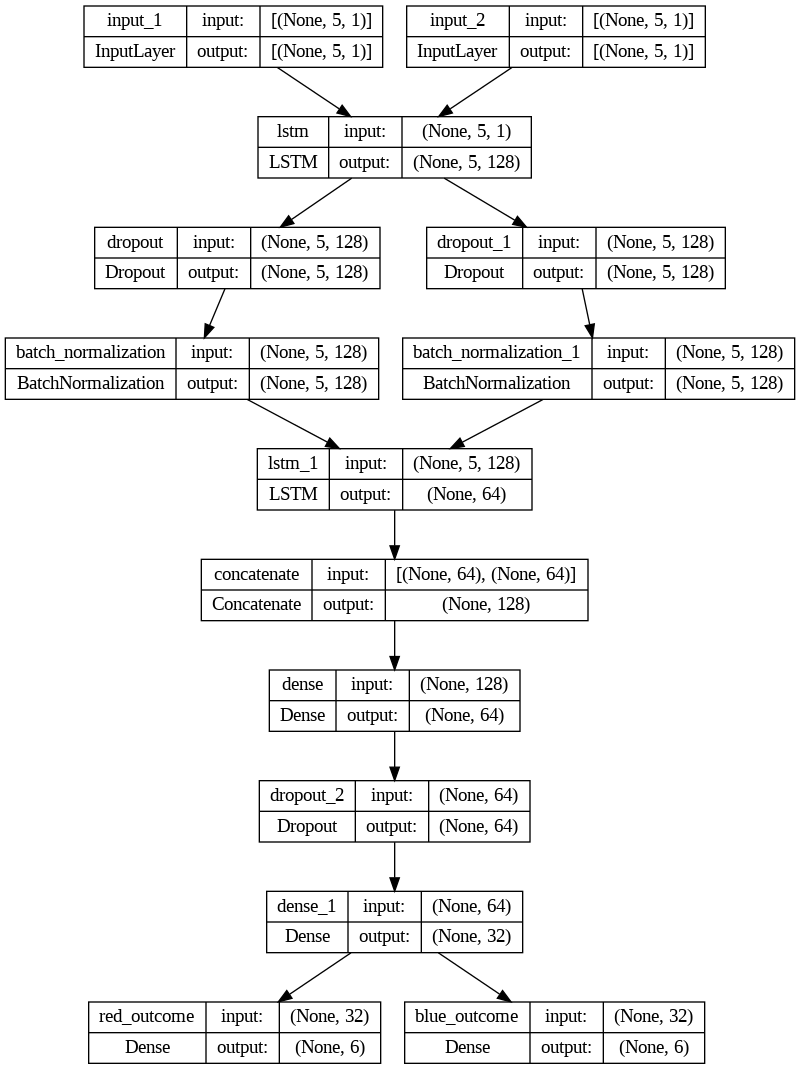

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Example test data
red_list  = [1,3,2,6,5]
blue_list = [6,4,4,5,5]
test_data_red = np.array([red_list])
test_data_blue = np.array([blue_list])

# Predict the top 3 most probable outcomes for red and blue dice
predicted_red_prob, predicted_blue_prob = model.predict([test_data_red.reshape(-1, seq_length, 1),
                                                         test_data_blue.reshape(-1, seq_length, 1)])

# Extract the top 3 outcomes with highest probabilities
top_3_red_indices = np.argsort(-predicted_red_prob[0])[:3]
top_3_blue_indices = np.argsort(-predicted_blue_prob[0])[:3]

# Convert back to actual dice outcomes (adding 1 as the outcomes are 0-indexed)
top_3_red_outcomes = top_3_red_indices + 1
top_3_blue_outcomes = top_3_blue_indices + 1

# Calculate the percentage of possibility for each outcome
top_3_red_probs = predicted_red_prob[0][top_3_red_indices]
top_3_red_probs_percent = top_3_red_probs / np.sum(top_3_red_probs) * 100

top_3_blue_probs = predicted_blue_prob[0][top_3_blue_indices]
top_3_blue_probs_percent = top_3_blue_probs / np.sum(top_3_blue_probs) * 100

# Print the top 3 most probable outcomes and their probabilities for red and blue dice
print("Top 3 Most Probable Outcomes for Red Dice:", top_3_red_outcomes)
print("Probability of Top 3 Outcomes for Red Dice:", top_3_red_probs_percent)
print("Top 3 Most Probable Outcomes for Blue Dice:", top_3_blue_outcomes)
print("Probability of Top 3 Outcomes for Blue Dice:", top_3_blue_probs_percent)


1/1 [==============================] - 0s 23ms/step
Top 3 Most Probable Outcomes for Red Dice: [3 4 6]
Probability of Top 3 Outcomes for Red Dice: [64.82059   30.579466   4.5999517]
Top 3 Most Probable Outcomes for Blue Dice: [3 2 6]
Probability of Top 3 Outcomes for Blue Dice: [49.716984  46.466618   3.8163972]


###Transformers below

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Embedding
from tensorflow.keras.layers import MultiHeadAttention, TimeDistributed, Concatenate, Flatten

In [ ]:
# Load data from the CSV file
data = pd.read_csv("data.csv")

# Convert the lists in the first and second columns to NumPy arrays
X_red = np.array([eval(lst) for lst in data["red"].values])
X_blue = np.array([eval(lst) for lst in data["blue"].values])
Y_red, Y_blue = zip(*data["outcome"].apply(eval))

In [ ]:
# Convert the target labels to sequences of length 5 for both red and blue dice
Y_red_sequences = [Y_red[i:i+5] for i in range(len(Y_red) - 4)]
Y_blue_sequences = [Y_blue[i:i+5] for i in range(len(Y_blue) - 4)]

# Convert the target labels to 2D NumPy arrays
Y_red_sequences = np.array(Y_red_sequences, dtype=np.int32)
Y_blue_sequences = np.array(Y_blue_sequences, dtype=np.int32)
Y_blue_sequences

In [ ]:
# Model Architecture
seq_length = 5
vocab_size = 7  # The dice outcomes are from 1 to 6, so add 1 for padding (0) and an extra token for out-of-vocabulary (OOV)

# Create the Transformer model for red dice
input_red = Input(shape=(seq_length,))
embedding_red = Embedding(input_dim=vocab_size, output_dim=128)(input_red)
qkv_red = MultiHeadAttention(key_dim=128, num_heads=4)(embedding_red, embedding_red, embedding_red)
encoder_output_red = Dropout(0.2)(qkv_red)
encoder_output_red = LayerNormalization(epsilon=1e-6)(encoder_output_red)
encoder_output_red = TimeDistributed(Dense(128, activation='relu'))(encoder_output_red)
encoder_output_red = TimeDistributed(Dense(vocab_size, activation='softmax'))(encoder_output_red)

# Create the Transformer model for blue dice
input_blue = Input(shape=(seq_length,))
embedding_blue = Embedding(input_dim=vocab_size, output_dim=128)(input_blue)
qkv_blue = MultiHeadAttention(key_dim=128, num_heads=4)(embedding_blue, embedding_blue, embedding_blue)
encoder_output_blue = Dropout(0.2)(qkv_blue)
encoder_output_blue = LayerNormalization(epsilon=1e-6)(encoder_output_blue)
encoder_output_blue = TimeDistributed(Dense(128, activation='relu'))(encoder_output_blue)
encoder_output_blue = TimeDistributed(Dense(vocab_size, activation='softmax'))(encoder_output_blue)

In [ ]:
# Attention mechanism to capture interdependence
attention = MultiHeadAttention(key_dim=128, num_heads=4)(encoder_output_red, encoder_output_blue, encoder_output_blue)
encoder_output_red_with_attention = Concatenate(axis=2)([encoder_output_red, attention])
encoder_output_blue_with_attention = Concatenate(axis=2)([encoder_output_blue, attention])

# Final prediction layers for red and blue dice
output_red = TimeDistributed(Dense(vocab_size, activation='softmax'), name='output_red')(encoder_output_red_with_attention)
output_blue = TimeDistributed(Dense(vocab_size, activation='softmax'), name='output_blue')(encoder_output_blue_with_attention)

model = Model(inputs=[input_red, input_blue], outputs=[output_red, output_blue])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit([X_red[:-4], X_blue[:-4]], [Y_red_sequences, Y_blue_sequences], epochs=100, batch_size=32, verbose=1)

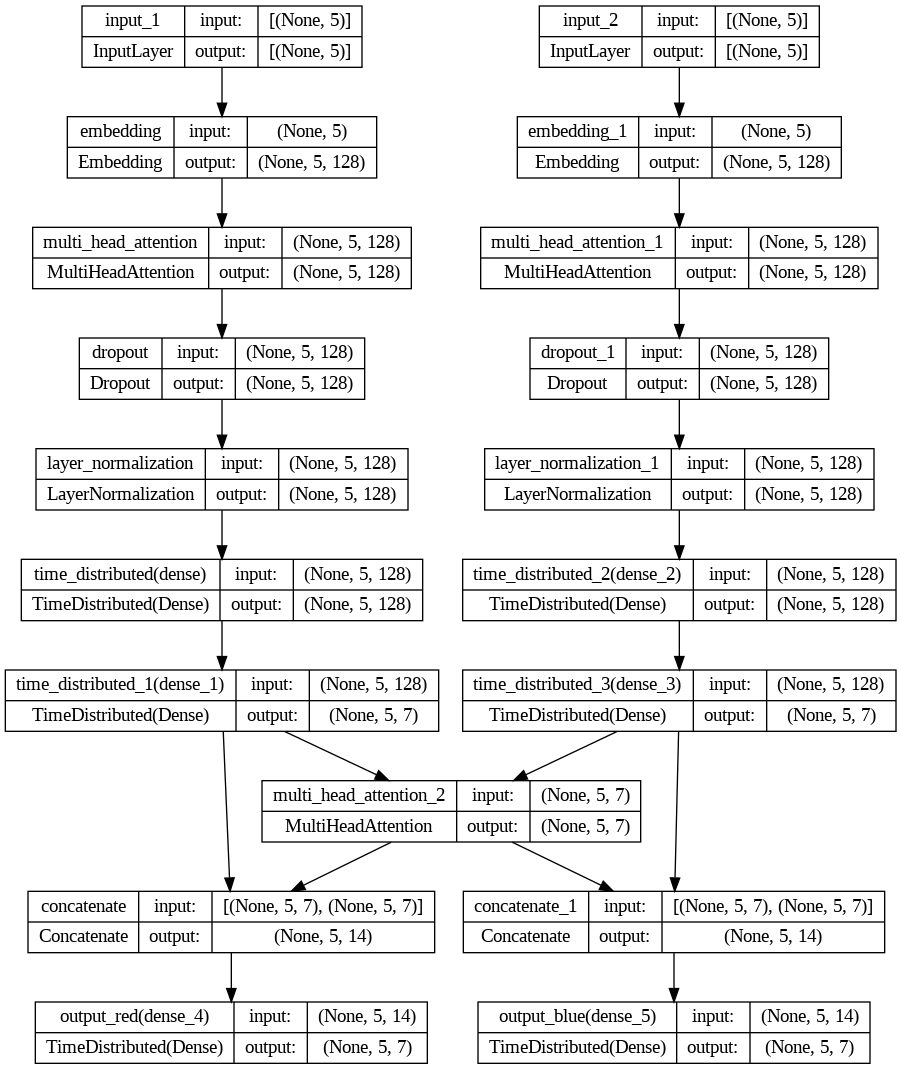

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Example test data
test_data_red = np.array([[2, 4, 3, 6, 1]])
test_data_blue = np.array([[1, 4, 2, 6, 3]])

# Predict the probabilities of outcomes for red and blue dice
predicted_probs_red, predicted_probs_blue = model.predict([test_data_red, test_data_blue])

# Extract the top 3 outcomes with highest probabilities for each dice
top_3_red_outcomes = np.argsort(-predicted_probs_red[0][0])[:3] + 1
top_3_blue_outcomes = np.argsort(-predicted_probs_blue[0][0])[:3] + 1

# Calculate the percentage of possibility for each outcome
top_3_red_probs = predicted_probs_red[0][0][top_3_red_outcomes - 1]
top_3_red_probs_percent = top_3_red_probs / np.sum(top_3_red_probs) * 100

top_3_blue_probs = predicted_probs_blue[0][0][top_3_blue_outcomes - 1]
top_3_blue_probs_percent = top_3_blue_probs / np.sum(top_3_blue_probs) * 100

# Print the top 3 most probable outcomes and their probabilities for red and blue dice
print("Top 3 Most Probable Outcomes for Red Dice:", top_3_red_outcomes)
print("Probability of Top 3 Outcomes for Red Dice:", top_3_red_probs_percent)
print("Top 3 Most Probable Outcomes for Blue Dice:", top_3_blue_outcomes)
print("Probability of Top 3 Outcomes for Blue Dice:", top_3_blue_probs_percent)


### Dataset Script

In [ ]:
import pandas as pd

def update_dataframe(list1, list2):
    # Create an empty list to store room data
    room_data = []
    room_data.append({'List1': list1.copy(), 'List2': list2.copy(), 'Num_list': []})

    def update_lists(num1, num2):
        # Remove the first elements from both lists
        list1.pop(0)
        list2.pop(0)

        # Append the new numbers at the end of each list
        list1.append(num1)
        list2.append(num2)

        # Update Num_list in the previous row
        room_data[-1]['Num_list'] = [num1, num2]

        # Append room data to the list for the new row
        room_data.append({'List1': list1.copy(), 'List2': list2.copy(), 'Num_list': []})

    while True:
        num1 = int(input("Enter num1: "))
        num2 = int(input("Enter num2: "))
        update_lists(num1, num2)

        df = pd.DataFrame(room_data)
        print(df.tail(2))

        continue_updates = input("Do you want to continue updating? (y/n): ")
        if continue_updates.lower() == 'n':
            break

    # Save DataFrame to CSV file in the current working directory
    df.to_csv('updated_dataframe.csv', index=False)
    print("DataFrame saved to 'updated_dataframe.csv' in the current working directory.")

# Example usage:
list1 = [3, 6, 3, 4, 3]
list2 = [2, 2, 1, 4, 5]

update_dataframe(list1, list2)